In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

In [2]:
from environment import CryptoEnvironment, ETFEnvironment
from utils import *

# Deep RL Agent

In [33]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.50 # if greater than 0.5 than it is exploiting
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

# Training agent

In [34]:
N_ASSETS = 53 #15
agent = Agent(N_ASSETS)
env = ETFEnvironment()

In [35]:
window_size = 180
episode_count = 50
batch_size = 32
rebalance_period = 90

Episode 0/50 epsilon 1.0


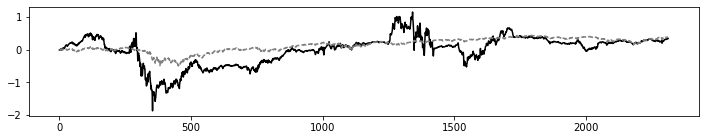

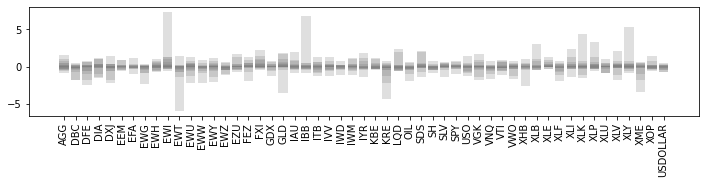

Episode 1/50 epsilon 1.0


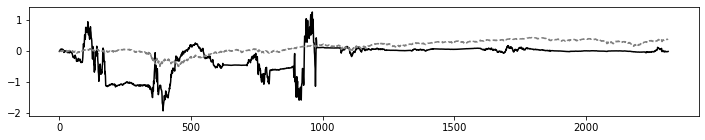

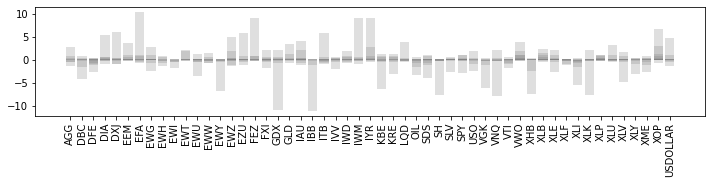

Episode 2/50 epsilon 0.5


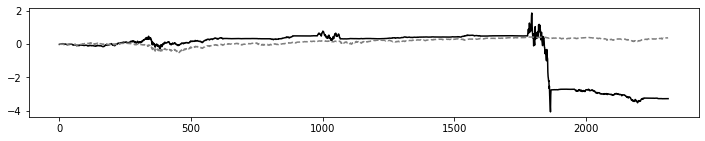

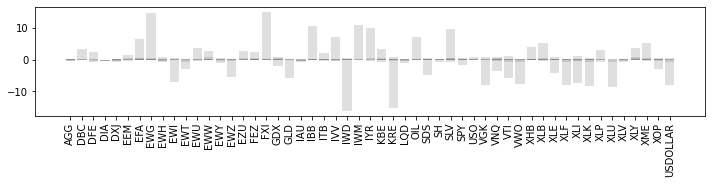

Episode 3/50 epsilon 0.25


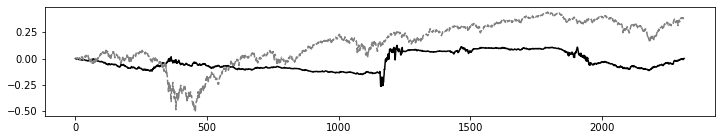

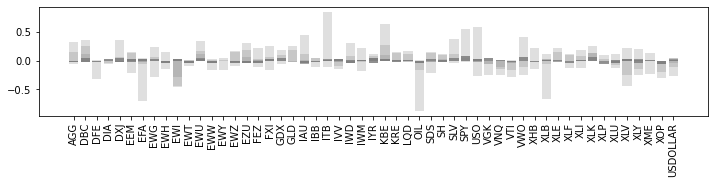

Episode 4/50 epsilon 0.125


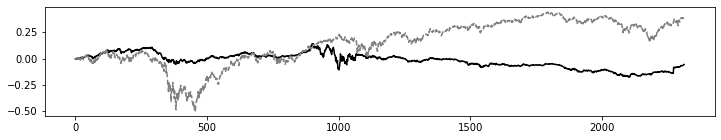

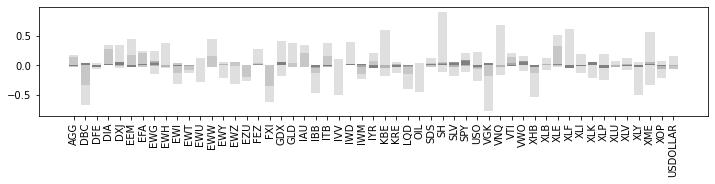

Episode 5/50 epsilon 0.0625


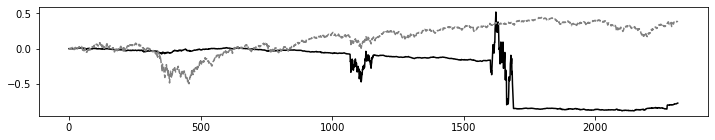

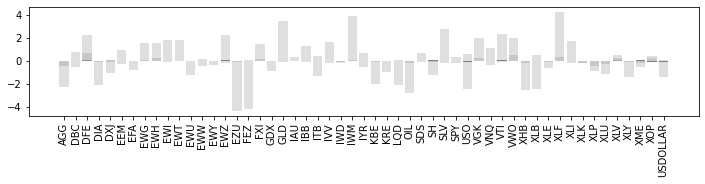

Episode 6/50 epsilon 0.0625


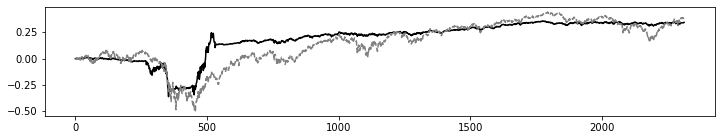

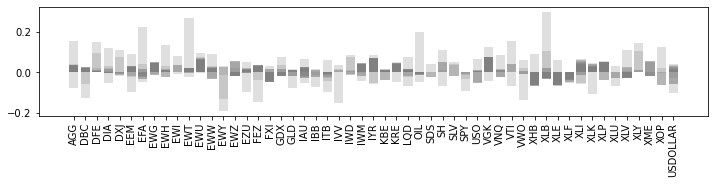

Episode 7/50 epsilon 0.03125


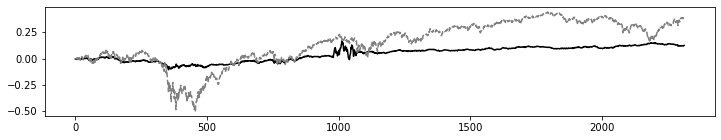

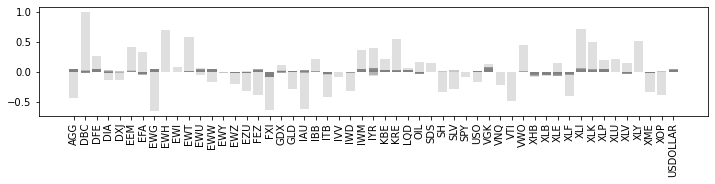

Episode 8/50 epsilon 0.015625


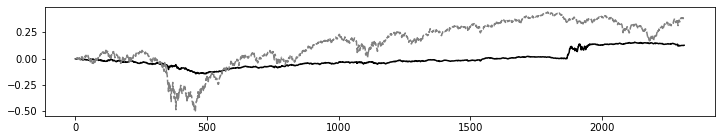

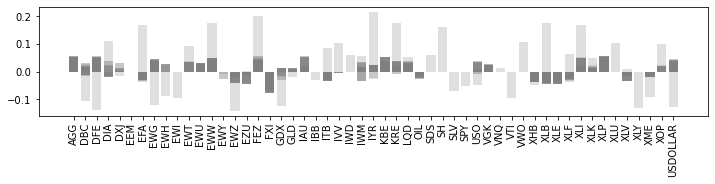

Episode 9/50 epsilon 0.0078125


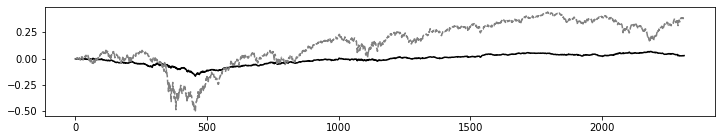

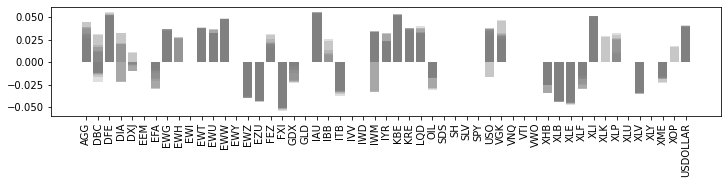

Episode 10/50 epsilon 0.0078125


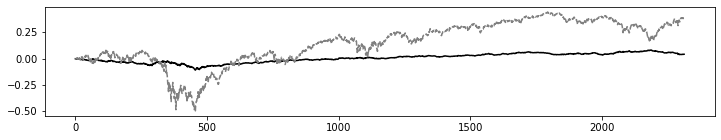

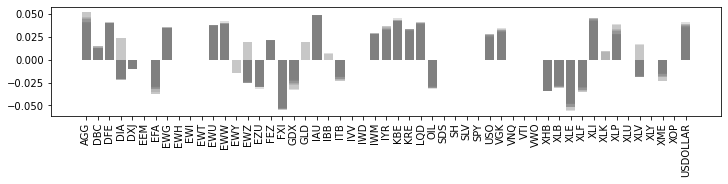

Episode 11/50 epsilon 0.0078125


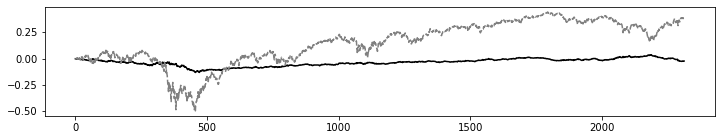

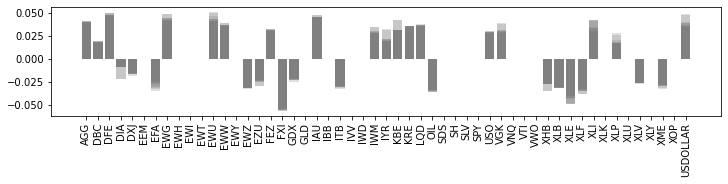

Episode 12/50 epsilon 0.0078125


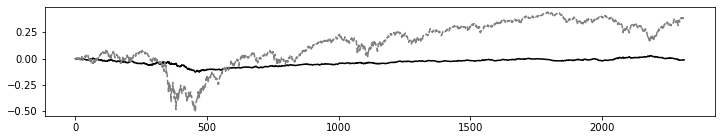

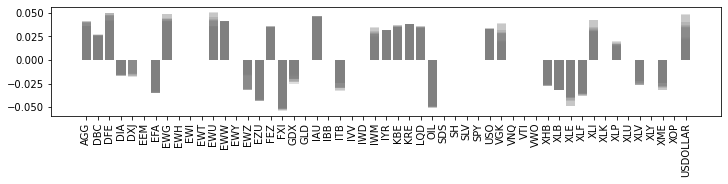

Episode 13/50 epsilon 0.0078125


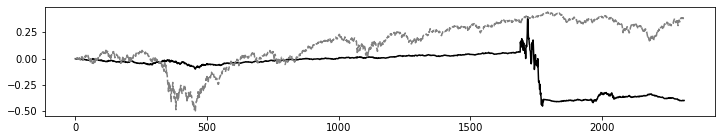

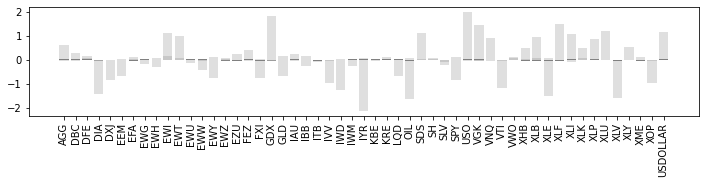

Episode 14/50 epsilon 0.0078125


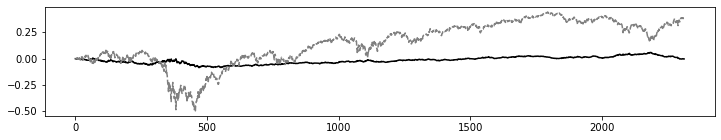

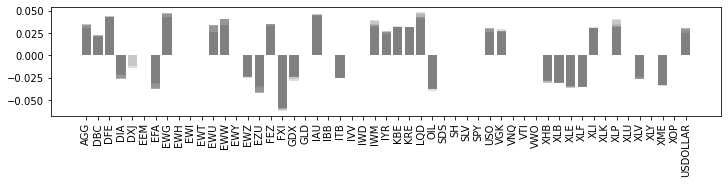

Episode 15/50 epsilon 0.0078125


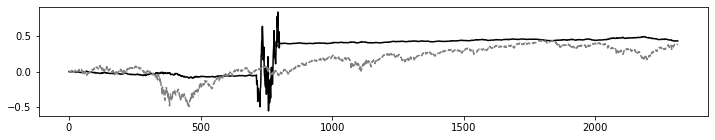

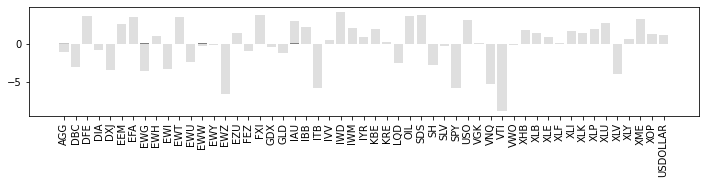

Episode 16/50 epsilon 0.0078125


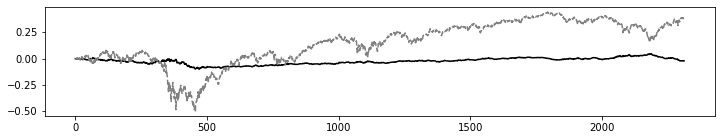

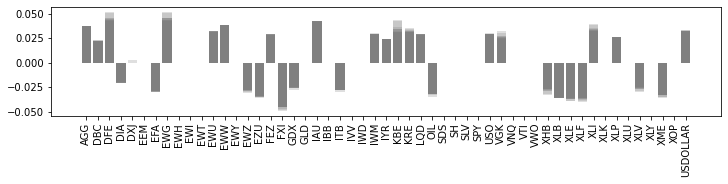

Episode 17/50 epsilon 0.0078125


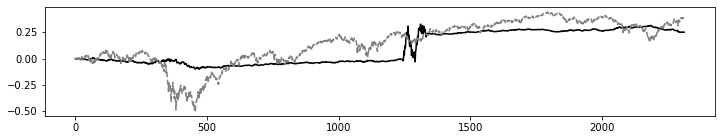

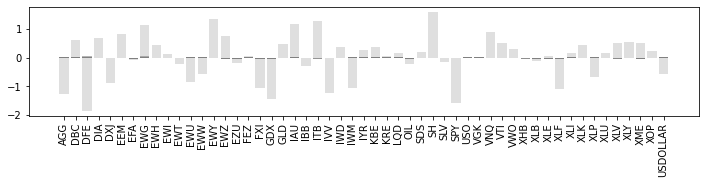

Episode 18/50 epsilon 0.0078125


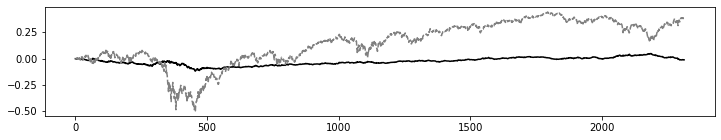

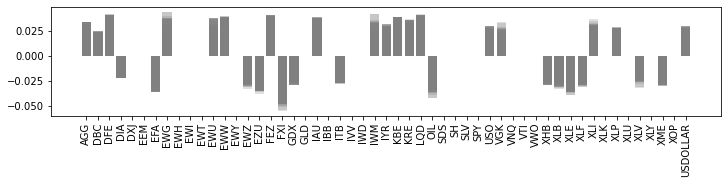

Episode 19/50 epsilon 0.0078125


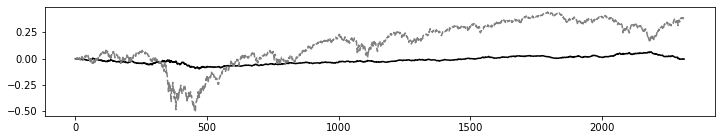

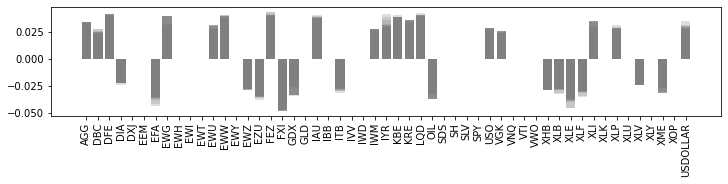

Episode 20/50 epsilon 0.0078125


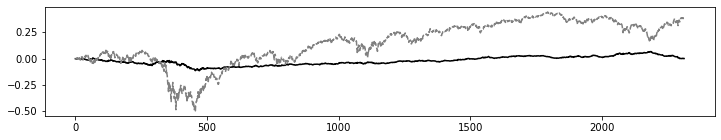

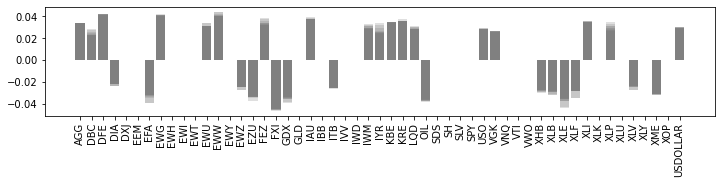

Episode 21/50 epsilon 0.0078125


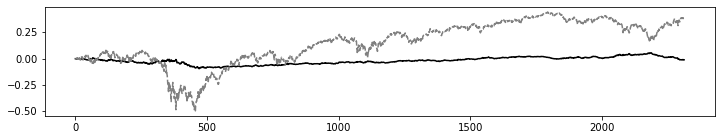

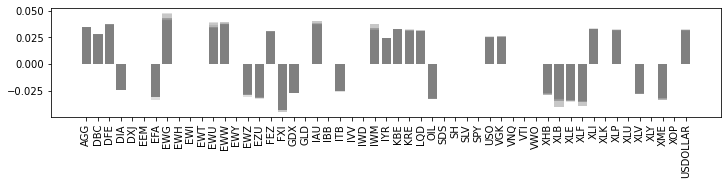

Episode 22/50 epsilon 0.0078125


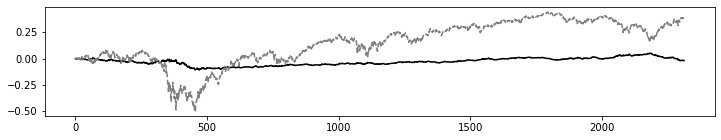

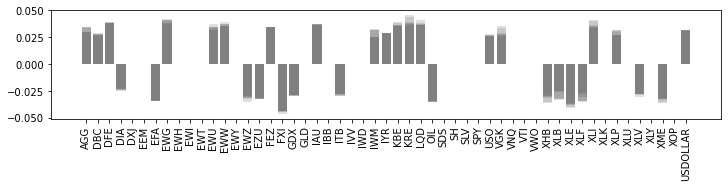

Episode 23/50 epsilon 0.0078125


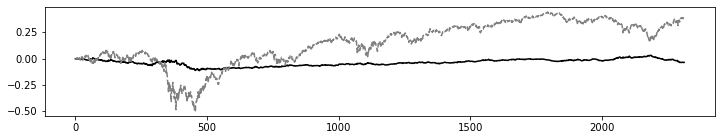

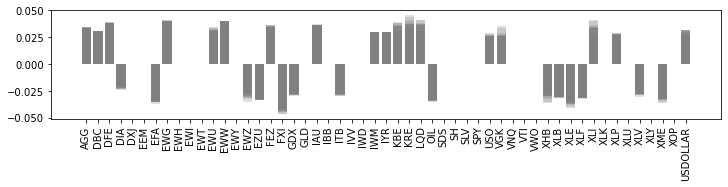

Episode 24/50 epsilon 0.0078125


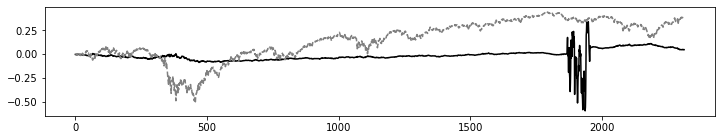

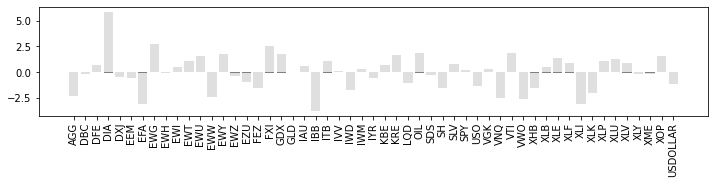

Episode 25/50 epsilon 0.0078125


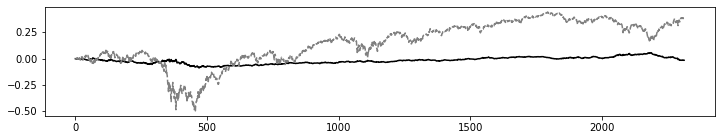

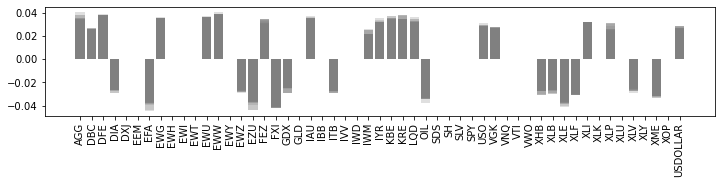

Episode 26/50 epsilon 0.0078125


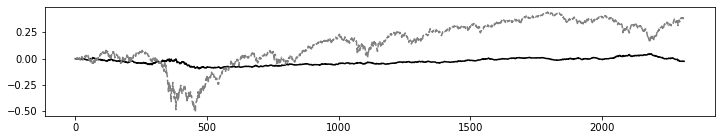

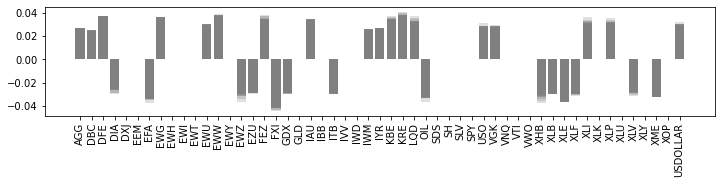

Episode 27/50 epsilon 0.0078125


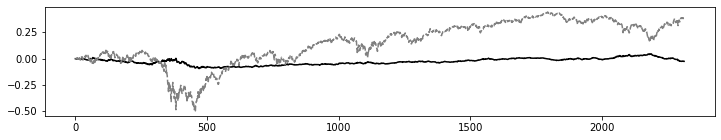

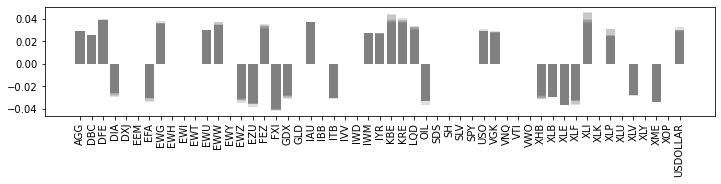

Episode 28/50 epsilon 0.0078125


In [ ]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()
    

# Evaluating agent

In [ ]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [ ]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

In [ ]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'result_equal_vis')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'result_rl_vis')
plt.legend()
plt.show()

In [ ]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

In [ ]:
plot_results(result_equal, 
             result_rl, 
             actions_rl, 
             N_ASSETS,
             env.data.columns, 
             'Deep RL portfolio', './images_test1/rl/', 'series')

# Making GIFs

In [ ]:
import imageio
import glob
import os

In [ ]:
name = 'rl'
filenames = glob.glob('./images_test1/' + name + '/series*.jpg')
filenames.sort(key=lambda x: os.path.getmtime(x))
filenames

In [ ]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./images_test1/' + name + '_gif.gif', images, duration=0.5)